# Unmapping

## The problem

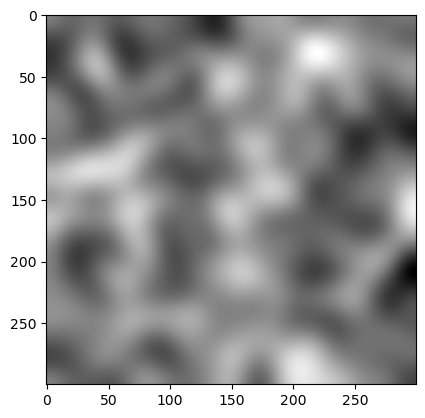

In [202]:
import scipy.ndimage as snd
import numpy as np
import matplotlib.pyplot as plt

raw = np.random.random((300, 300))
arr = snd.gaussian_filter(raw, 13)
arr = (arr - arr.min()) / (arr.max() - arr.min())
plt.imshow(arr, cmap='gray')
# plt.colorbar()

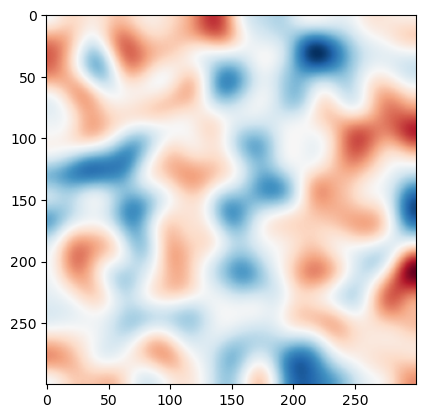

In [203]:
rgb = plt.get_cmap('RdBu')(arr)[..., :3]

plt.imshow(rgb)

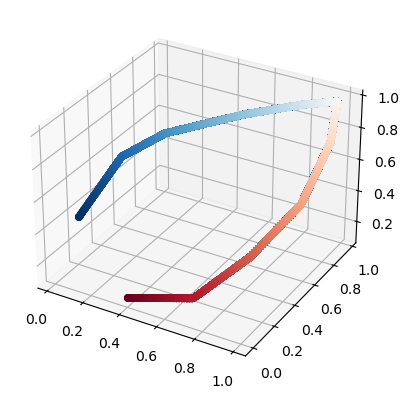

In [204]:
im1d = rgb.reshape(-1, 3)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(*im1d.T)
ax.scatter(*im1d.T, c=im1d)

## Doing a lookup

If you have the cmap, it's easy:

In [177]:
cmap = plt.get_cmap('jet')(np.linspace(0, 1, 256))[..., :3]
cmap

array([[0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
       [0.00000000e+00, 0.00000000e+00, 5.17825312e-01],
       [0.00000000e+00, 0.00000000e+00, 5.35650624e-01],
       [0.00000000e+00, 0.00000000e+00, 5.53475936e-01],
       [0.00000000e+00, 0.00000000e+00, 5.71301248e-01],
       [0.00000000e+00, 0.00000000e+00, 5.89126560e-01],
       [0.00000000e+00, 0.00000000e+00, 6.06951872e-01],
       [0.00000000e+00, 0.00000000e+00, 6.24777184e-01],
       [0.00000000e+00, 0.00000000e+00, 6.42602496e-01],
       [0.00000000e+00, 0.00000000e+00, 6.60427807e-01],
       [0.00000000e+00, 0.00000000e+00, 6.78253119e-01],
       [0.00000000e+00, 0.00000000e+00, 6.96078431e-01],
       [0.00000000e+00, 0.00000000e+00, 7.13903743e-01],
       [0.00000000e+00, 0.00000000e+00, 7.31729055e-01],
       [0.00000000e+00, 0.00000000e+00, 7.49554367e-01],
       [0.00000000e+00, 0.00000000e+00, 7.67379679e-01],
       [0.00000000e+00, 0.00000000e+00, 7.85204991e-01],
       [0.00000000e+00, 0.00000

In [178]:
all(px in cmap for px in im1d)

True

### What's the problem?

It doesn't work on actual images.

There are various reasons the CMAP you have won't match the colours in the image exactly. 

- slightly wrong cmap
- image has been compressed
- image is a photo
- etc, etc

(300, 300, 3)

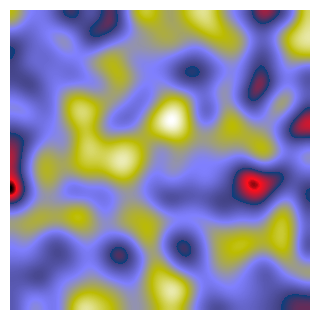

In [192]:
fig = plt.figure(frameon=False)
fig.set_size_inches(3, 3)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(arr, cmap='gist_stern')
plt.savefig('test.png')

img = Image.open('test.png')
ima = np.asarray(img)[..., :3] / 255
ima.shape

In [193]:
all(px in cmap for px in ima.reshape(-1, 3))

False

## Approximate lookup

Colours in the image might be wrong, eg because of compression AND colours won't match exactly

Couple of approaches: QUANTIZE the image, or do a NEAREST-NEIGHBOUR lookup on the colourmap

In practice may want to use both of these techniques

### Clustering

This is quite slow and in practice we might do it on a scaled-down image.

In [194]:
from sklearn.cluster import KMeans

clu = KMeans(n_clusters=256).fit(ima.reshape(-1, 3))
clu.cluster_centers_.shape

(256, 3)

### Lookup

In [195]:
from scipy.spatial import cKDTree

kdtree = cKDTree(cmap)
dist, ix = kdtree.query(ima)
rec = ix / ix.max()

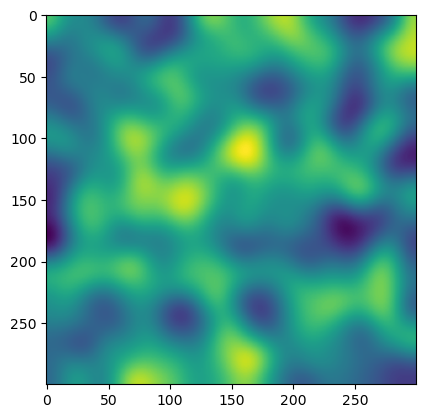

In [183]:
plt.imshow(rec)

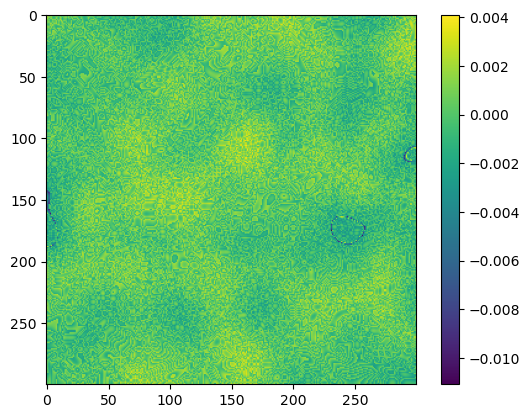

In [185]:
plt.imshow(rec - arr)
plt.colorbar()

## But we did all that with knowledge of the colormap

Look at the quantized image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


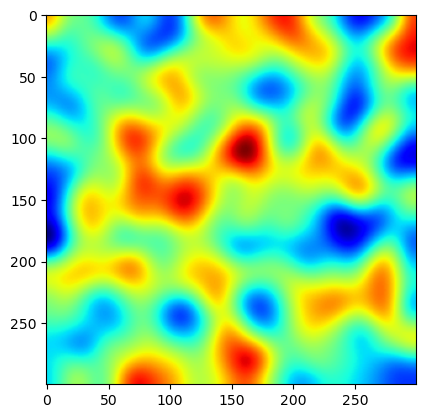

In [188]:
qnt = clu.cluster_centers_[clu.labels_].reshape(300, 300, 3)

plt.imshow(qnt)

In [190]:
from skimage.feature import graycomatrix

glcm = graycomatrix(clu.labels_].reshape(300, 300),
                    distances=[1],
                    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                    levels=256,
                    symmetric=True
                    )

ValueError: The parameter `image` must be a 2-dimensional array

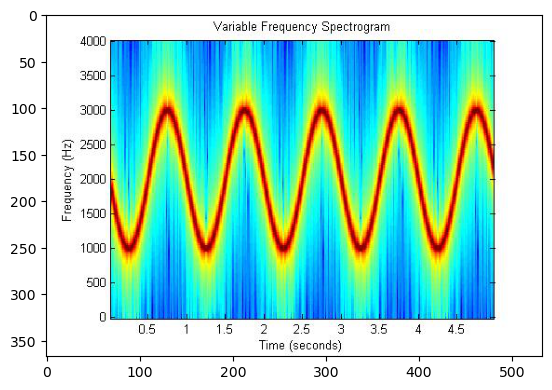

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

def get_image_from_web(uri):
    f, _ = urlretrieve(uri)
    img = Image.open(f).convert('RGB')
    rgb_im = np.asarray(img)[..., :3] / 255.
    return rgb_im

# Public domain image.
uri = 'https://upload.wikimedia.org/wikipedia/commons/2/2b/VariableFrequency.jpg'
img = get_image_from_web(uri)

plt.imshow(img)